# Stock Market Price Prediction with New Data

### Breif Overview:
The model created below is for prediction the stock prices of a Company.

There are two datasets

1. Stock Prices Dataset for 云南白药

2. news dataset

The notebook is briefly summarized as follows:

1. Data Preparation - Preparing data for evaluation.

2. Data Quality Checks - Performing basic checks on data for better understanding of data.

3. Feature inspection and filtering - Correlation and feature Mutual information plots against the target variable. Inspection of the Binary, categorical and other variables.

4. Feature importance ranking via learning models

5. Training - training data against multiple machine learning algorthms and fine tuning a couple of algorithms for accuracy

In [1]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
#from pandas import read_csv, set_option
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


## 1. Data Preparation:

### Step1: 输入股票数据

In [2]:
# Load the stock prices dataset into a dataframe and check the top 5 rows
stock_prices = "云南白药.csv"
stock_data = pd.read_csv(stock_prices, parse_dates=[0])
stock_data.columns = ['date', 'open', 'close', 'high', 'low', 'volume', 'money']
stock_data.head()

,date,open,close,high,low,volume,money
0,2017-01-03,72.58,67.79,72.69,66.34,30582502.0,2.113998e+09
1,2017-01-04,67.65,68.00,68.70,67.20,16737460.0,1.138144e+09
2,2017-01-05,67.96,66.62,68.45,66.44,12537991.0,8.446937e+08
3,2017-01-06,66.39,67.09,69.29,65.53,14472393.0,9.770961e+08
4,2017-01-09,67.09,69.04,70.48,67.09,16237252.0,1.120987e+09


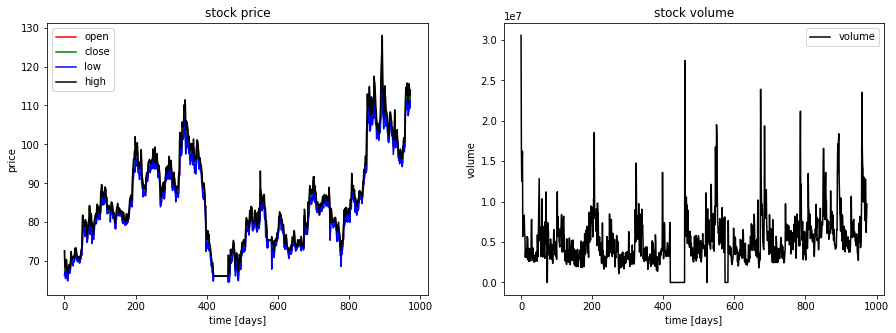

In [3]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(stock_data['open'].values, color='red', label='open')
plt.plot(stock_data['close'].values, color='green', label='close')
plt.plot(stock_data['low'].values, color='blue', label='low')
plt.plot(stock_data['high'].values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(stock_data['volume'].values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [4]:
# Check the shape and datatypes of the stock prices dataframe
print(stock_data.shape)
print(stock_data.dtypes)

(974, 7)
date      datetime64[ns]
open             float64
close            float64
high             float64
low              float64
volume           float64
money            float64
dtype: object


### Step2: 输入新闻情感分析

### Step3: 情感分析&新闻数据结合

In [5]:
merged_dataframe = stock_data
# Check the shape and datatypes of the merged dataframe
print(merged_dataframe.shape)
merged_dataframe.head()

(974, 7)


,date,open,close,high,low,volume,money
0,2017-01-03,72.58,67.79,72.69,66.34,30582502.0,2.113998e+09
1,2017-01-04,67.65,68.00,68.70,67.20,16737460.0,1.138144e+09
2,2017-01-05,67.96,66.62,68.45,66.44,12537991.0,8.446937e+08
3,2017-01-06,66.39,67.09,69.29,65.53,14472393.0,9.770961e+08
4,2017-01-09,67.09,69.04,70.48,67.09,16237252.0,1.120987e+09


## 2. Data Quality Checks:

#### Checked the statistics of individual columns in the dataframe.

In [6]:
# Check the statistics of the columns of the merged dataframe and check for outliers
print(merged_dataframe.describe())

             open       close        high         low        volume  \
count  974.000000  974.000000  974.000000  974.000000  9.740000e+02   
mean    84.952813   85.052136   86.126417   83.883203  5.152611e+06   
std     11.909804   11.948797   12.297479   11.543335  3.345373e+06   
min     64.850000   65.740000   66.170000   64.540000  0.000000e+00   
25%     75.395000   75.430000   76.377500   74.877500  3.138158e+06   
50%     83.120000   83.400000   84.120000   82.145000  4.544997e+06   
75%     93.615000   93.800000   94.760000   92.270000  6.348548e+06   
max    124.400000  125.400000  128.000000  118.030000  3.058250e+07   

              money  
count  9.740000e+02  
mean   4.503318e+08  
std    3.198445e+08  
min    0.000000e+00  
25%    2.570860e+08  
50%    3.812017e+08  
75%    5.616014e+08  
max    2.573757e+09  


#### Plotted histograms for individual columns to see the distribution of values.
#### The x axis is the column values and the y axis is the frequency of those values.
#### The plot below gives a fair idea of how the data is distributed across columns. We can see that most of the columns though not normally distributed are fairly evenly distributed across all the columns which is a good sign as we do not have to skew much with the data.

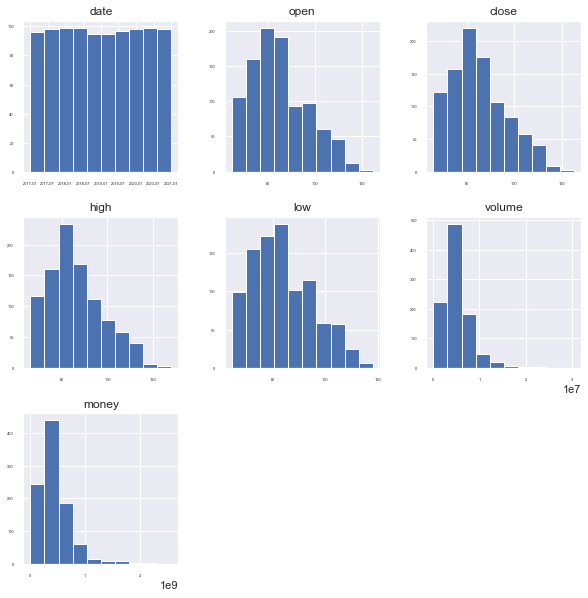

In [7]:
# Plot a histogram for all the columns of the dataframe. This shows the frequency of values in all the columns
sns.set()
merged_dataframe.hist(sharex = False, sharey = False, xlabelsize = 4, ylabelsize = 4, figsize=(10, 10))
pyplot.show()

## 3.Feature inspection and filtering

#### Lets check for NaN values in individual columns of the dataframe.

#### Visualizing the NaN's makes it easier for us to see where the NaN values are falling. Below is a plot of the NaN values. The white lines are the NaN values. In the below plot we are unable to see the NaN values because they are so less. We just have 3 NaN values in the first 4 columns each. The perpendicular bars on the last vertical lin shows exactly where the NaN values are falling.

#### In this case, since the NaN values are so less, it doesn't matter much in the prediction of the model. However, it is important for the NaN values to be replaced. As discuseed earlier, we will replace the NaN values with the mean value of the respective column.

<AxesSubplot:>

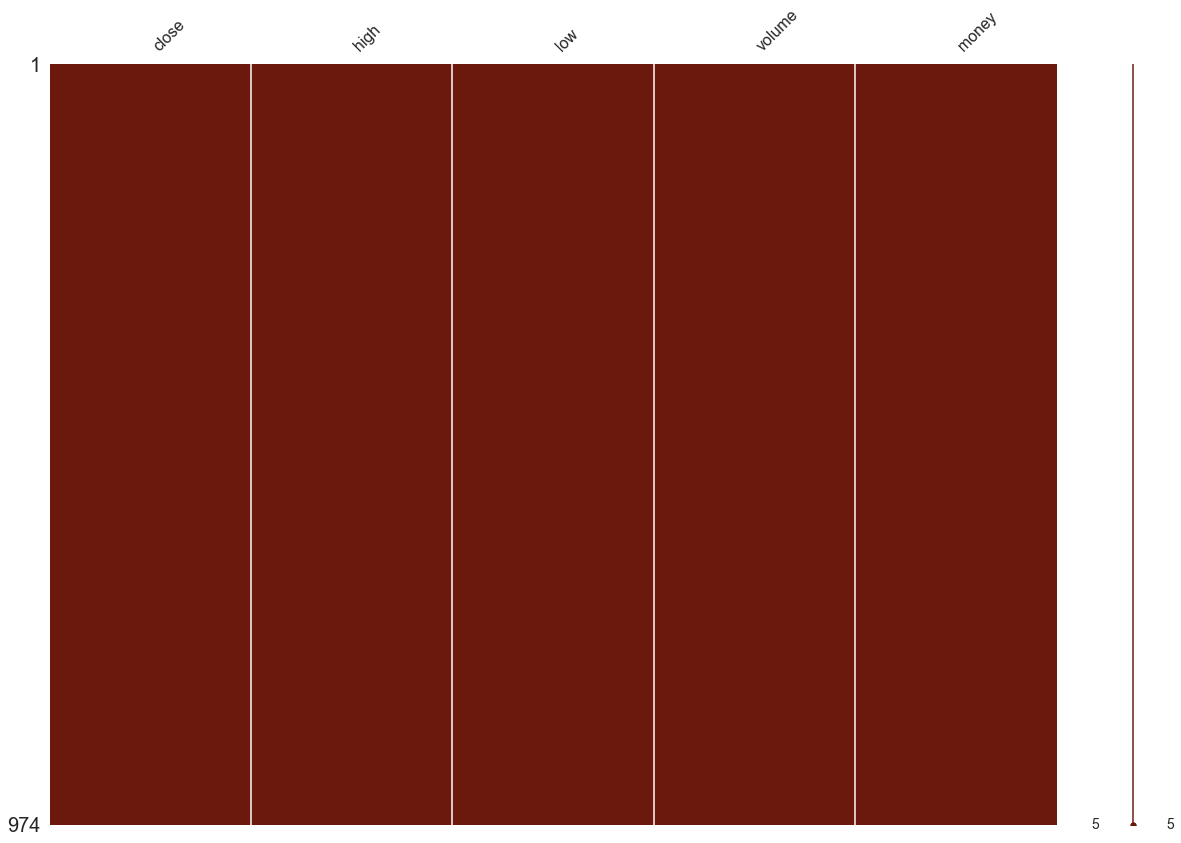

In [8]:
md_copy = merged_dataframe
md_copy = md_copy.replace(-1, np.NaN)
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=md_copy.iloc[:,2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

### Correlation Map for features:

#### Now, we will plot a heat map and a scatter matrix to see the correlation of the columns with each other.

#### You can see the heat map with pearson correlation values in the plot below.

#### This gave me a better understanding to see if there are any dependant variables or if any of the variables are highly correlated.

#### Some variables Subjectivity, Objectivity are negatively correlated. There are very few variables which seem to have a very high correlation. Thus, at this point we can conclude that we do not need any sort of dimensionality reduction technique to be applied.

#### Some machine learning algorithms require the predictor variables to not be highly correlated. If the predictors are highly correlated then all of the correlated predictors are basically representing the same correlation and either one or all the variables will have the same effect on the target variable. In such a case dimensionality reduction is required. 

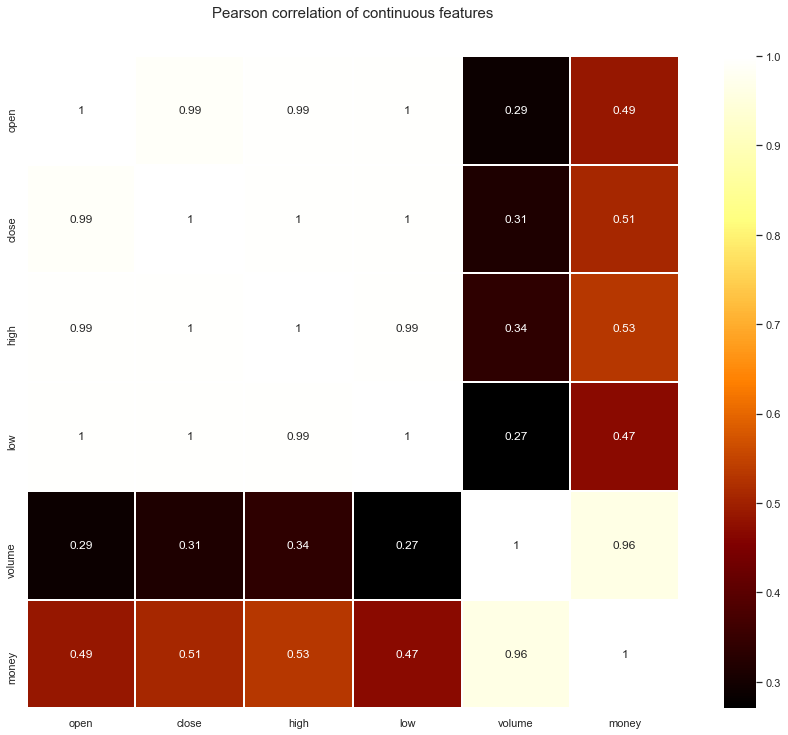

In [9]:
colormap = pyplot.cm.afmhot
pyplot.figure(figsize=(16,12))
pyplot.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(merged_dataframe.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)
pyplot.show()

## 4. Training:

### Steps being performed in the below cell:

Recheck the dataframe to see if the dataset is ready for train.

There are certain NaN values in many columns of the dataframe.

Replace the NaN values with the mean values of the respective column.

In our dataset, we have columns Subjectivity through Adj Close as inputs and the Label column output.

Now, we will split our dataset to training and test samples. Lets train out model on first 70% of the data 
and test our prediction model on remaining 30% of the data.

As this is a time series, it is important we do not randomly pick training and testing samples. A time series is a linear dataset where the data is in a chronological order. This requires the chronology to be preserved in while training the model and doing the prediction. This is why it is important to maintain a proper chronological split.

#### Lets consider a few machine learning algorithms to perform our training on.

After splitting the dataset, we can see that there are 1393 samples for training and 597 samples for testing



In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

import sklearn
from sklearn.preprocessing import MinMaxScaler

#### the original stock price

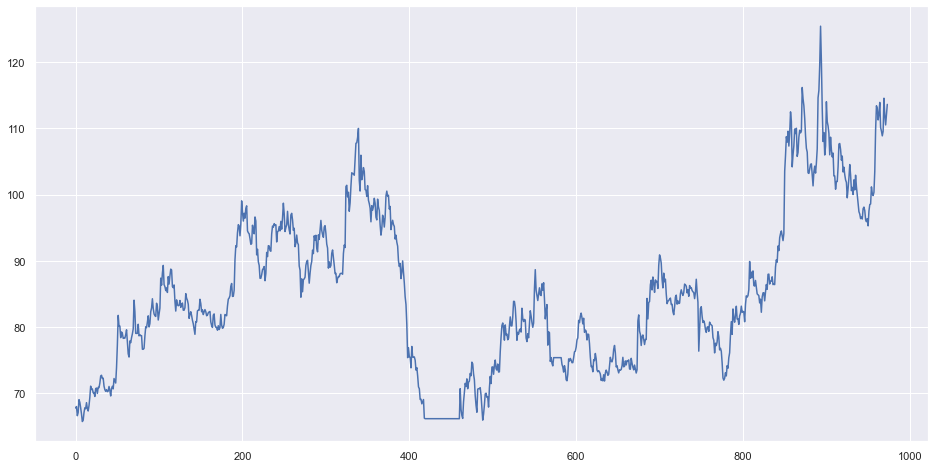

In [11]:
plt.figure(figsize=(16,8))
plt.plot(merged_dataframe["close"],label='Close Price history')

In [12]:
merged_dataframe.head()

,date,open,close,high,low,volume,money
0,2017-01-03,72.58,67.79,72.69,66.34,30582502.0,2.113998e+09
1,2017-01-04,67.65,68.00,68.70,67.20,16737460.0,1.138144e+09
2,2017-01-05,67.96,66.62,68.45,66.44,12537991.0,8.446937e+08
3,2017-01-06,66.39,67.09,69.29,65.53,14472393.0,9.770961e+08
4,2017-01-09,67.09,69.04,70.48,67.09,16237252.0,1.120987e+09


#### 不明白的东西

In [13]:
data=merged_dataframe.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(merged_dataframe)),columns=['date', 'close'])

for i in range(0,len(data)):
    new_dataset["date"][i]=data['date'][i]
    new_dataset["close"][i]=data["close"][i]
type(new_dataset)

news_part_dataset = pd.DataFrame(index=range(0,len(merged_dataframe)),columns=['close'])
for i in range(0,len(data)):
    news_part_dataset["close"][i]=data['close'][i]


In [14]:
final_dataset=new_dataset.values

stride = 3
news_stride = 1

len_train_data = len(final_dataset[0:int(len(final_dataset)*0.8),:])
len_valid_data = len(final_dataset[int(len(final_dataset)*0.8):,:])

new_dataset.index=new_dataset.date
new_dataset.drop("date",axis=1,inplace=True)
final_dataset=new_dataset.values

# for train data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)
news_part = scaler.fit_transform(news_part_dataset.values)

# for test data
inputs_data=new_dataset[len_train_data-stride:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

inputs_news_data=news_part_dataset[len_train_data-stride:].values
inputs_news_data=inputs_news_data.reshape(-1,1)
inputs_news_data=scaler.transform(inputs_news_data)


# build the train features with time lag: stride
x_train_data,y_train_data=[],[]
for i in range(stride, len_train_data):
    # add two: stride - stocks, news_stride - news
    x_part1 = scaled_data[i-stride:i,0]
    x_part2 = news_part[i-stride:i,0]
    x_train_data.append(np.hstack((x_part1,x_part2)))
    y_train_data.append(scaled_data[i,0])
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
# reshaped the data into (#values, #time-steps, #1 dimensional output).
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))


# build the test features with time lag: stride
X_test=[]
for i in range(stride, inputs_data.shape[0]):
    # add two: stride - stocks, news_stride - news
    x_part1 = inputs_data[i-stride:i,0]
    x_part2 = inputs_news_data[i-stride:i,0]
    X_test.append(np.hstack((x_part1,x_part2)))
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

#### LSTM model

In [15]:
# define model
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

# compile
lstm_model.compile(loss='mean_squared_error',optimizer='adam')

# model summary
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


#### Train

In [16]:
# train
lstm_model.fit(x_train_data,y_train_data,epochs=20,batch_size=1,verbose=2)

Epoch 1/20
776/776 - 4s - loss: 0.0024
Epoch 2/20
776/776 - 2s - loss: 0.0015
Epoch 3/20
776/776 - 2s - loss: 0.0016
Epoch 4/20
776/776 - 2s - loss: 0.0013
Epoch 5/20
776/776 - 2s - loss: 0.0014
Epoch 6/20
776/776 - 2s - loss: 0.0013
Epoch 7/20
776/776 - 2s - loss: 0.0012
Epoch 8/20
776/776 - 2s - loss: 0.0010
Epoch 9/20
776/776 - 2s - loss: 9.7875e-04
Epoch 10/20
776/776 - 2s - loss: 8.7706e-04
Epoch 11/20
776/776 - 2s - loss: 8.9492e-04
Epoch 12/20
776/776 - 2s - loss: 9.1172e-04
Epoch 13/20
776/776 - 2s - loss: 9.3206e-04
Epoch 14/20
776/776 - 2s - loss: 7.9228e-04
Epoch 15/20
776/776 - 2s - loss: 8.4377e-04
Epoch 16/20
776/776 - 2s - loss: 8.2754e-04
Epoch 17/20
776/776 - 2s - loss: 8.6412e-04
Epoch 18/20
776/776 - 2s - loss: 8.6772e-04
Epoch 19/20
776/776 - 2s - loss: 8.9336e-04
Epoch 20/20
776/776 - 2s - loss: 7.9591e-04


#### Test

In [17]:
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

#### show result

             close  Predictions
date                           
2020-03-18   73.11    72.429596
2020-03-19   72.62    73.248741
2020-03-20   74.17    72.608650
2020-03-23   73.78    74.413353
2020-03-24   75.36    73.674446
...            ...          ...
2020-12-25  114.53   108.088074
2020-12-28  111.98   112.041954
2020-12-29   110.5   109.020744
2020-12-30   112.0   109.484314
2020-12-31   113.6   110.434982

[195 rows x 2 columns]
0.9820372429882321


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


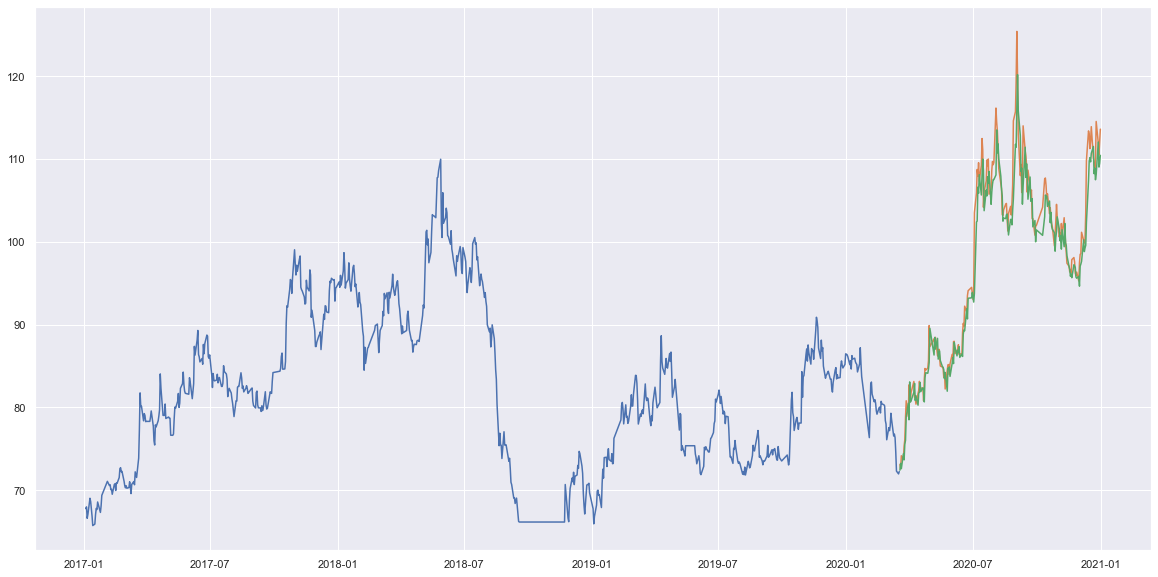

In [18]:
train_data=new_dataset[:int(len(final_dataset)*0.8)]
valid_data=new_dataset[int(len(final_dataset)*0.8):]
valid_data['Predictions']=predicted_closing_price
print(valid_data[['close',"Predictions"]])
gt_res = valid_data['close'].values.tolist()
pre_res = valid_data['Predictions'].values.tolist()
acc = 0
for i in range(len(gt_res)):
    acc += abs(gt_res[i] - pre_res[i]) / gt_res[i]
acc = 1 - acc / len(gt_res)
print(acc)
plt.plot(train_data["close"])
plt.plot(valid_data[['close',"Predictions"]])